<h4>Bing Internal Product Consistency Analysis</h4>
<p>This notebook focuses solely on evaluating Bing’s product recommendation consistency for comparison with ChatGPT’s results.
While the ChatGPT notebook explored multiple aspects of internal consistency (including CQMIPO), 
the present analysis is limited to computing Bing’s Cross Query Mean Internal Product Overlap (CQMIPO) 
to enable a direct, controlled comparison.</p>

<p>For each query, the top ten organic search results were collected. Web content from each URL was scraped, and the main products mentioned were extracted using the Gemini API.
These extracted product sets are used to quantify Bing’s CQMIPO across related queries 
and to compare it directly with ChatGPT’s CQMIPO.</p>

In [1]:
import random
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_bing_df
from metrics import semantic_overlap
from plots import boxplot, heatmaps
from utility import top_n_semantic_products

In [2]:
random.seed(2025)

<h4>Dataset: Bing</h4>

In [3]:
bing_df = get_bing_df()
bing_df

,query,product,market_type,query_level,content,url,domain,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[The Best Phones We've Tested for 2025 | PCMag...,"[https://www.pcmag.com/picks/the-best-phones, ...","[pcmag.com, tomsguide.com, techradar.com, zdne...","[[Apple iPhone 17, Samsung Galaxy S25 Ultra, S..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,[Top Smartphones Under $1000 About UsTrendingR...,[https://www.analyticsinsight.net/gadgets/best...,"[analyticsinsight.net, techwiser.com, techspec...","[[Samsung Galaxy S25, iPhone 16 Pro, Google Pi..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,[9 Best Camera Phones Under $1000 for Amazing ...,[https://www.techwisehub.com/blog/best-camera-...,"[techwisehub.com, techwiser.com, amateurphotog...","[[Samsung Galaxy S25, iPhone 16, Google Pixel ..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[Best Phones Under $1000 (August 2025) - TechW...,[https://techwiser.com/best-phones-under-1000-...,"[techwiser.com, pcmag.com, techspecs.info, ana...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Plus..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[The Best Laptops We've Tested (September 2025...,"[https://www.pcmag.com/picks/the-best-laptops,...","[pcmag.com, nytimes.com, tomsguide.com, zdnet....","[[Dell 14 Plus (DB14250), Dell Precision 5690,..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[10 Best Laptops 2025 Under $1500: Complete Gu...,[https://gadgetsandall.com/10-best-laptops-202...,"[gadgetsandall.com, gizmodo.com, dockuniverse....","[[Apple MacBook Air 13″ (M4), ASUS ROG Strix G..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[10 Best Laptops Under $1500 for 2025: Perform...,[https://dockuniverse.com/best-laptops-for-150...,"[dockuniverse.com, pcmag.com, dockuniverse.com...",[[MSI Titan 18 HX Gaming Laptop (A14VIG-036US)...
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[10 Best Laptops Under $1500 for 2025: Perform...,[https://dockuniverse.com/best-laptops-for-150...,"[dockuniverse.com, pcmag.com, gizmodo.com, ofz...","[[MSI Titan 18 HX, ASUS Zenbook 14, MSI Titan ..."
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,[The Best Smartwatches We've Tested for 2025 |...,[https://www.pcmag.com/picks/the-best-smartwat...,"[pcmag.com, forbes.com, tomsguide.com, techrad...","[[Apple Watch Series 11, Samsung Galaxy Watch ..."
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,[Best budget smartwatches: 6 cheap but good op...,[https://www.wareable.com/smartwatches/best-ch...,"[wareable.com, tomsguide.com, pcmag.com, techr...","[[Amazfit Active 2, Huawei Watch Fit 3, Xiaomi..."


<h4>Cross-Query Mean Internal Product Overlap – Definition & Implementation</h4>

<p> 
To evaluate the consistency of Bing’s product recommendations across related queries, we compute the Cross-Query Mean Internal Product Overlap (CQMIPO). It quantifies the <em>average semantic similarity</em> between the sets of products recommended for any two queries $ i $ and $ j $. 
</p> 

<p> 
Formally, for each query $ q $, let the set of product lists extracted from Bing be $ P_{Bing_q} = [p_{q1}, p_{q2}, p_{q3}] $. To measure overlap between two distinct queries $ i $ and $ j $, we define: 
</p> 

<p>
$$ CQMIPO[i, j] = \frac{1}{|P_{Bing_i}|\,|P_{Bing_j}|} \sum_{u=1}^{|P_{Bing_i}|} \sum_{v=1}^{|P_{Bing_j}|} O_{\text{semantic}}(p_{iu}, p_{jv}) $$ </p> 

<p> 
where $ O_{\text{semantic}}(p_{iu}, p_{jv}) $ represents the semantic overlap between individual product lists $ p_{iu} $ and $ p_{jv} $. Higher CQMIPO values indicate stronger internal consistency in Bing’s product recommendations. 
</p>

<p>
Since Bing produces ten product lists per query (versus ChatGPT’s three), we apply random subsampling without replacement to select three lists per query before computing CQMIPO.
This normalization ensures comparable dimensionality and fairness in the consistency analysis.
<p/>

In [4]:
def calc_cqmipo(bing_df, filter_col = None):
    
    n = len(bing_df)
    cqmipo_matrix = np.full((n, n), 0, dtype = float)

    # ! added for comparing Bing to ChatGPT !
    product_lists = []
    for prods in bing_df["recommended_products"].tolist():
        product_lists.append(random.sample(prods, 3))
    
    # filter
    filter_values = bing_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                semantic_overlap(a, b)
                for a in product_lists[i]
                for b in product_lists[j]
            ]
            cqmipo = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmipo_matrix[i, j] = cqmipo
            cqmipo_matrix[j, i] = cqmipo
    
    return pd.DataFrame(cqmipo_matrix, index = bing_df["query"], columns = bing_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

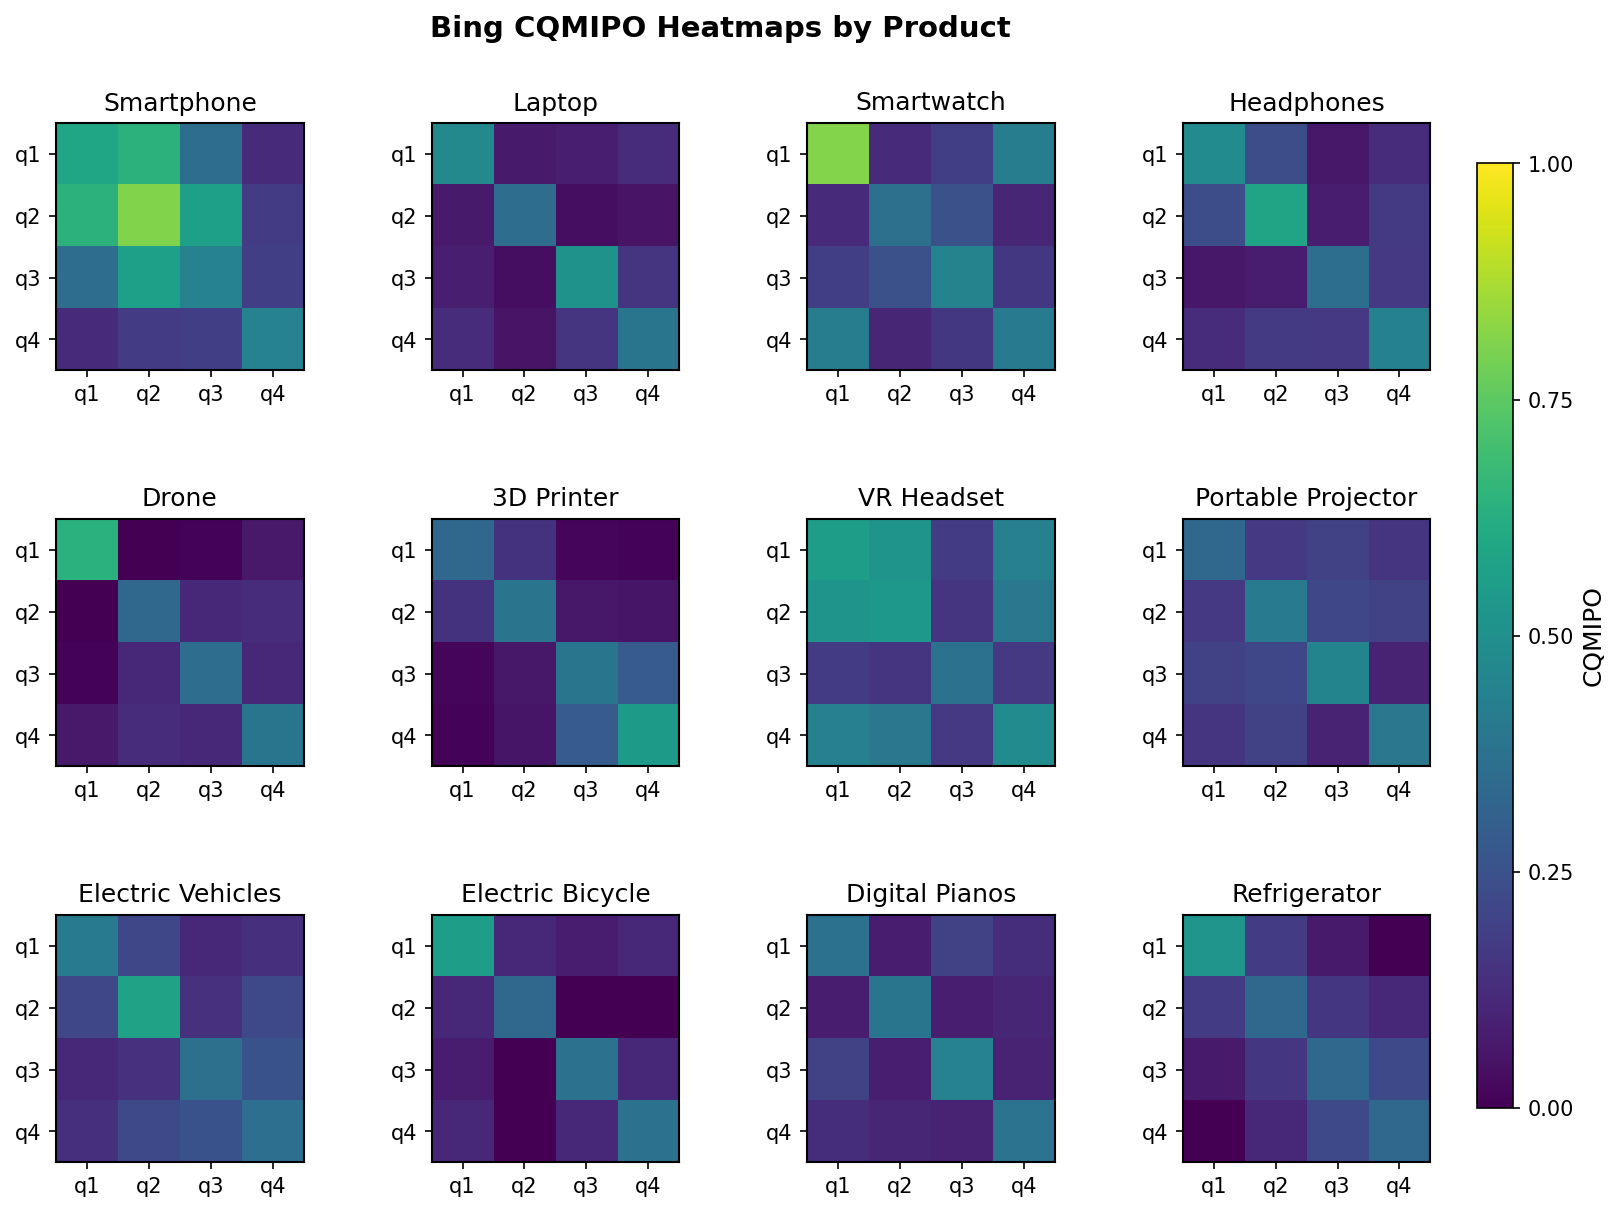

In [5]:
cqmipo_matrix_p = calc_cqmipo(bing_df, filter_col = "product")
heatmaps(cqmipo_matrix_p, bing_df, filter_col = "product", title = "Bing CQMIPO Heatmaps by Product", colorbar_label = "CQMIPO")

In [6]:
def calc_cqopo(bing_df, filter_col = "product", top_n = 10):
    n = len(bing_df)
    cqopo_matrix = np.full((n, n), 0, dtype = float)
    # product_lists = bing_df["recommended_products"].tolist()

    # ! added for comparing Bing to ChatGPT !
    product_lists = []
    for prods in bing_df["recommended_products"].tolist():
        product_lists.append(random.sample(prods, 3))
    
    # filter
    filter_values = bing_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue

            list_i = top_n_semantic_products(product_lists[i], top_n = top_n)
            list_j = top_n_semantic_products(product_lists[j], top_n = top_n)
            
            cqmipo = semantic_overlap(list_i, list_j)
            cqopo_matrix[i, j] = cqmipo
            cqopo_matrix[j, i] = cqmipo
    
    return pd.DataFrame(cqopo_matrix, index = bing_df["query"], columns = bing_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

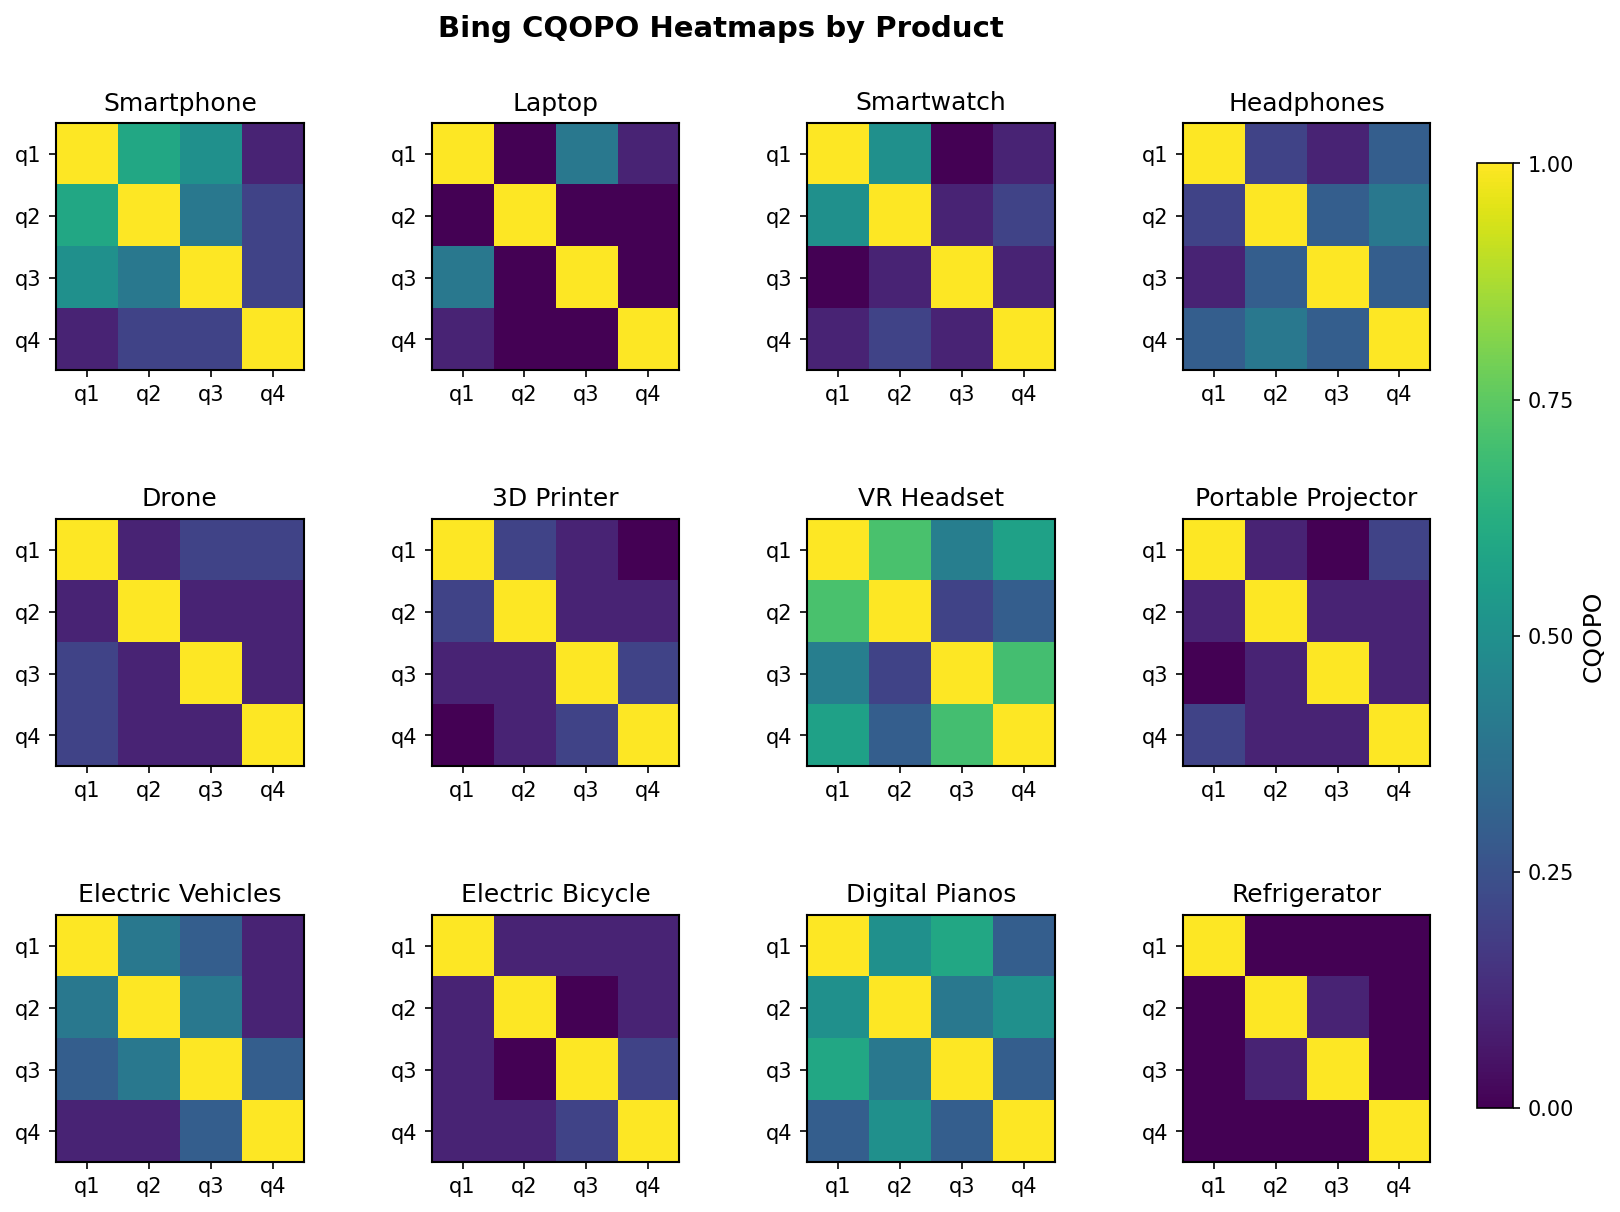

In [9]:
cqopo_mat_p = calc_cqopo(bing_df, filter_col = "product", top_n = 10)
heatmaps(cqopo_mat_p, bing_df, filter_col = "product", title = "Bing CQOPO Heatmaps by Product", colorbar_label = "CQOPO")